In [1]:
#TODO czy zapisywać Logging interval ? 
#TODO i czy zapisywać całkowity number of epochs gdyby we wczytanym modelu robić kolejnego checkpointa
from data_helper import get_dataloaders_and_standarscaler_photons, get_dataloaders_and_standarscaler_photons_other_shape
from train_helper import train_vae, train_vae_mmd
from plot_helper import plot_training_loss

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import time
import seaborn as sns

# from sklearn import preprocessing
# from sklearn.decomposition import PCA
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms

In [2]:
from loss_function_helper import MMD_loss
mmd_loss_func=MMD_loss()
a=torch.tensor([[4,4,4],[4,4,4]])
b=torch.tensor([[4,2,3],[4,4,4]])
print(a)

tensor([[4, 4, 4],
        [4, 4, 4]])


In [3]:
mmd_loss_func(a,b)

tensor(1.9358)

In [4]:
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 10000
NUM_EPOCHS = 30
LOGGING_INTERVAL=250
RECONSTRUCTION_TERM_WEIGHT=1
SAVE_MODEL_FILE='checkpoint.pth'
path='/data1/dose-3d-generative/data/training-data/DISP_0.5_ANGLE_0/NUMPY/a1_10_7.npy'

In [5]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [6]:
print(torch.cuda.memory_allocated(device=DEVICE))
print(torch.cuda.memory_cached(device=DEVICE))

0
0


/opt/anaconda/anaconda3/envs/generative/lib/python3.9/site-packages/torch/cuda/memory.py:384: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [7]:
#ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
photons = np.load(path)
X = np.zeros((10000001, 6),dtype=np.float32)
np.copyto(X,photons[:,:-1])
print(X.shape)

(10000001, 6)


In [8]:
df_data = pd.DataFrame(X, columns = ['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df_data.head()#zawsze warto rzucić okiem na dane

,X,Y,dX,dY,dZ,E
0,0.77526,-0.50856,-4.60704,-0.018979,-0.177872,0.983871
1,0.77526,-0.77813,-5.10840,-0.029292,-0.196501,0.980066
2,0.45010,-3.74409,-1.33591,-0.145330,-0.051869,0.988023
3,0.39630,-2.50916,-3.30103,-0.274393,-0.273584,0.921879
4,0.45010,-4.79711,-1.70242,-0.184824,-0.065606,0.980579


In [9]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_photons_other_shape(path=path,
    batch_size=BATCH_SIZE, 
    num_workers=0,
    test_fraction=0.2, 
    validation_fraction=0.0)

In [10]:
#TWORZENIE ITERATORA PRZYDATNEGO W PĘTLI UCZĄCEJ MODELU
dataiter_train=iter(train_loader)
data_train=dataiter_train.next()
features_train = data_train

print(features_train.shape)

#TWORZENIE ITERATORA ZBIORU TESTOWEGO 
dataiter_test=iter(test_loader)
data_test=dataiter_test.next()
features_test = data_test


torch.Size([10000, 6])


In [11]:
#MODEL NASZEJ SIECI 13->13->7->3
class VAE_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(6, 5),
            #nn.BatchNorm1d(5),
            nn.ReLU(),
            # nn.Linear(5, 4),
            nn.BatchNorm1d(5),
            torch.nn.Linear(5,4),
            nn.BatchNorm1d(4),
            nn.ReLU(),
            # nn.ReLU(),
        )

        self.z_mean=nn.Sequential(
            # torch.nn.Linear(4,3),
            # nn.BatchNorm1d(3),
            # nn.ReLU(),
            nn.Linear(4,3)
            )

        self.z_log_var=nn.Sequential(
            # torch.nn.Linear(4,3),
            # nn.BatchNorm1d(3),
            # nn.ReLU(),
            nn.Linear(4,3)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(3,4),
            nn.ReLU(),
            nn.BatchNorm1d(4),
            nn.Linear(4, 5),
            nn.ReLU(),
            nn.BatchNorm1d(5),
            # nn.Linear(4,5),
            # nn.ReLU(),
            #nn.BatchNorm1d(5),
            nn.Linear(5,6)
            
           # nn.Sigmoid()
        )
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())#get_device dziala tylko dla tensoróœ z gpu
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def reparameterize_for_cpu(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cpu')#get_device dziala tylko dla tensoróœ z gpu
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [12]:
model = VAE_Linear()
model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE, 
                             weight_decay=1e-5)

In [13]:
log_dict=train_vae_mmd(num_epochs=NUM_EPOCHS, device=DEVICE, model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, test_loader=test_loader, logging_interval=LOGGING_INTERVAL, reconstruction_term_weight=RECONSTRUCTION_TERM_WEIGHT, save_model_file=SAVE_MODEL_FILE)

Epoch: 001/030 | Batch 0000/0800 | Loss: 10.5104
Epoch: 001/030 | Batch 0250/0800 | Loss: 6.0449
Epoch: 001/030 | Batch 0500/0800 | Loss: 4.4068
Epoch: 001/030 | Batch 0750/0800 | Loss: 2.9122
***Epoch: 001/030 | Loss: 2.519
Test***Epoch: 001/030 | Loss: 2.522
Time elapsed: 13.18 min
Epoch: 002/030 | Batch 0000/0800 | Loss: 2.6785
Epoch: 002/030 | Batch 0250/0800 | Loss: 2.0584
Epoch: 002/030 | Batch 0500/0800 | Loss: 1.7422
Epoch: 002/030 | Batch 0750/0800 | Loss: 1.6383
***Epoch: 002/030 | Loss: 1.609
Test***Epoch: 002/030 | Loss: 1.611
Time elapsed: 26.21 min
Epoch: 003/030 | Batch 0000/0800 | Loss: 1.6844
Epoch: 003/030 | Batch 0250/0800 | Loss: 1.6410
Epoch: 003/030 | Batch 0500/0800 | Loss: 1.2570
Epoch: 003/030 | Batch 0750/0800 | Loss: 0.9116
***Epoch: 003/030 | Loss: 0.867
Test***Epoch: 003/030 | Loss: 0.870
Time elapsed: 39.22 min
Epoch: 004/030 | Batch 0000/0800 | Loss: 0.8515
Epoch: 004/030 | Batch 0250/0800 | Loss: 0.7767
Epoch: 004/030 | Batch 0500/0800 | Loss: 0.6978
Epo

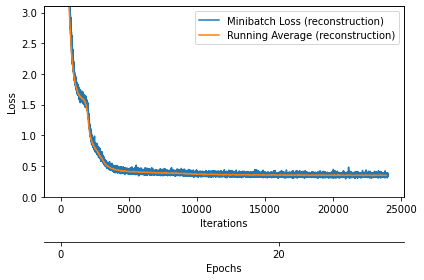

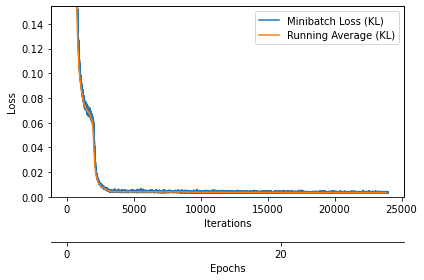

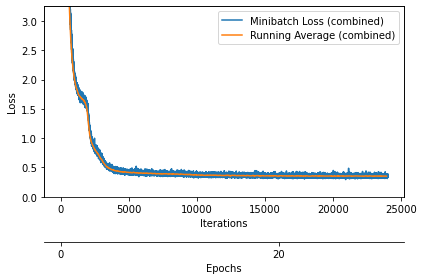

In [14]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()



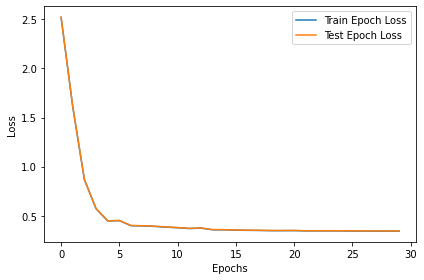

In [15]:
plt.plot(range(len(log_dict['train_combined_loss_per_epoch'])), (log_dict['train_combined_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_combined_loss_per_epoch'])), (log_dict['test_combined_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()

In [16]:
tmp=df_data.to_numpy(dtype=np.float32)
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
model.eval()
with torch.no_grad():
    result_encoded_features, z_mean, z_log_var, result_decoded_features =model(tmp.to(device=DEVICE))
result=result_decoded_features.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

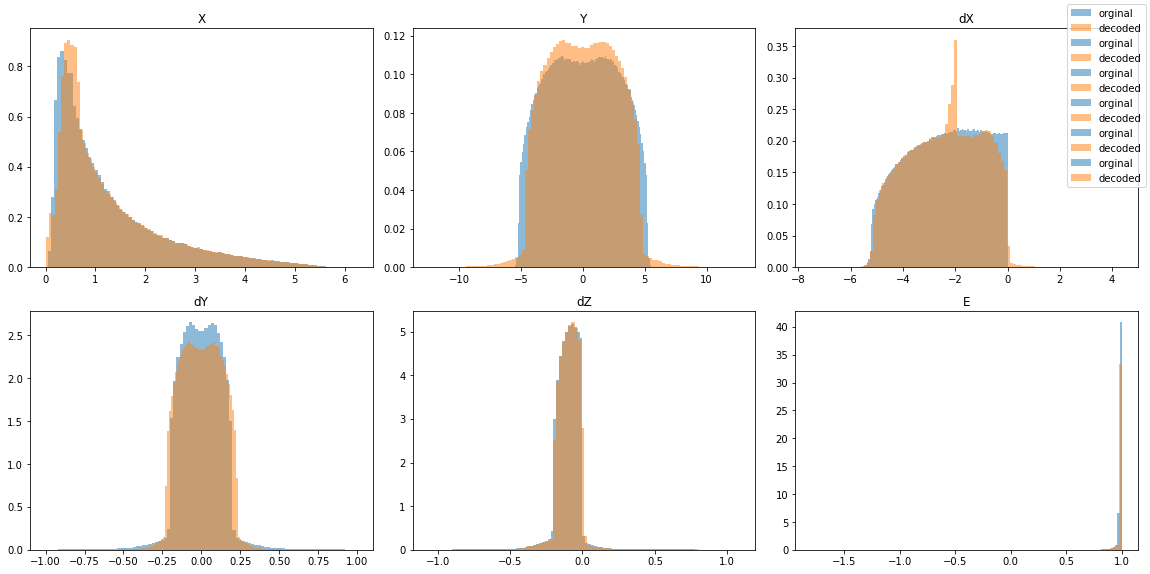

In [17]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
bins=100
axs[0, 0].hist(orginal[:,0],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 0].hist(result[:,0],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 0].set_title('X')
axs[0, 1].hist(orginal[:,1],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 1].hist(result[:,1],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 1].set_title('Y')
axs[0, 2].hist(orginal[:,2],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[0, 2].hist(result[:,2],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[0, 2].set_title('dX')
axs[1, 0].hist(orginal[:,3],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 0].hist(result[:,3],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 0].set_title('dY')
axs[1, 1].hist(orginal[:,4],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 1].hist(result[:,4],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 1].set_title('dZ')
axs[1, 2].hist(orginal[:,5],bins=bins, label ='orginal',alpha=0.5, density=True)
axs[1, 2].hist(result[:,5],bins=bins, label ='decoded', alpha=0.5, density=True)
axs[1, 2].set_title('E')
fig.legend()

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

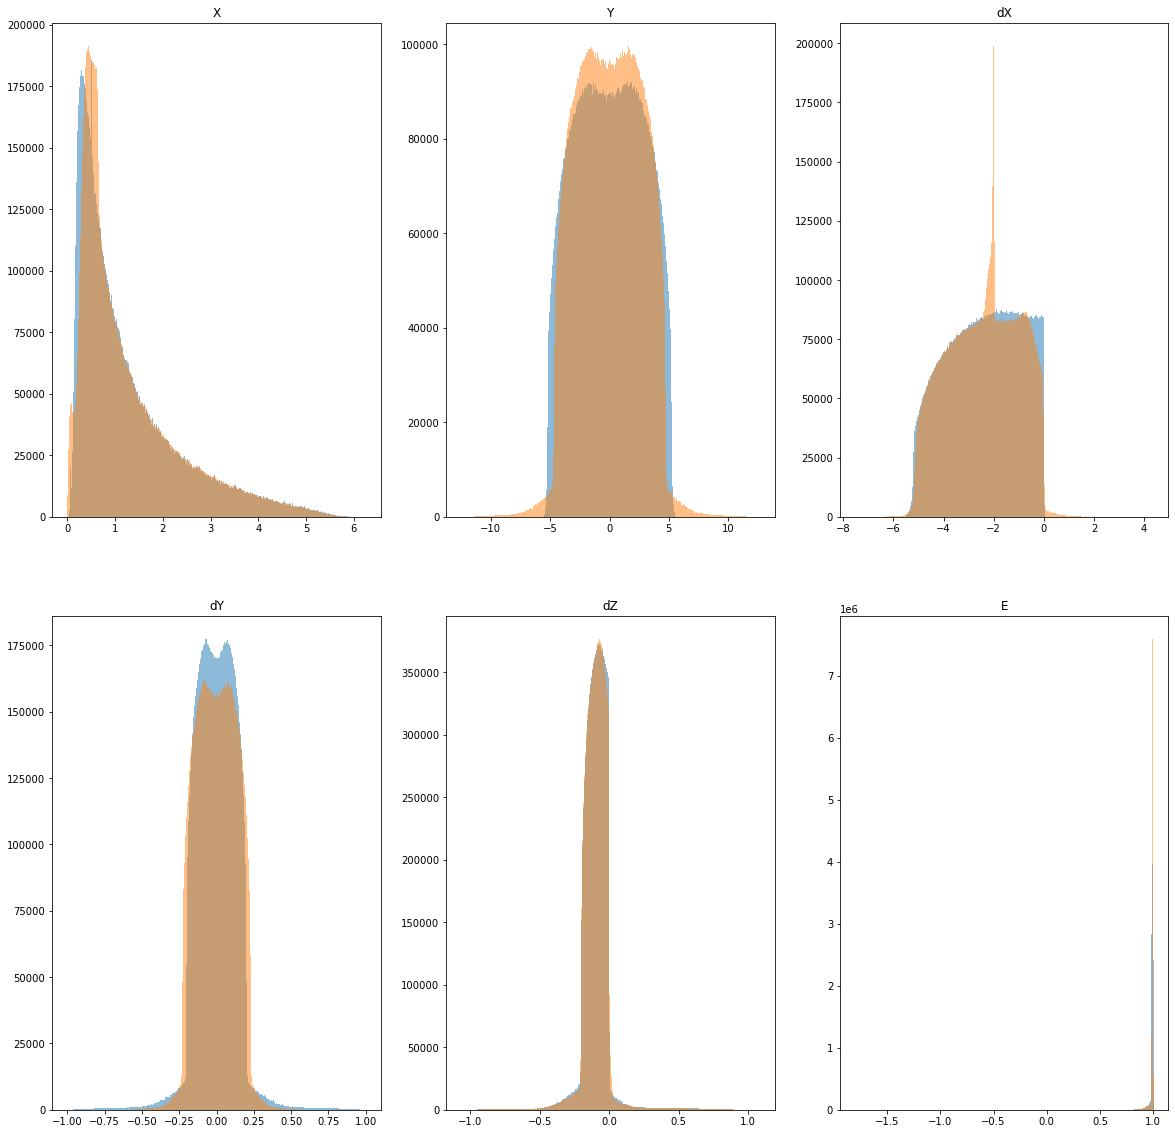

In [18]:
keys = df_data.columns
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(20, 20)
for i, j in enumerate(keys):
    mi = np.minimum(orginal[:, i].min(), result[:, i].min())
    ma = np.maximum(orginal[:, i].max(), result[:, i].max())
    bins = np.linspace(mi, ma, 300)
    axs.flatten()[i].hist(orginal[:, i], bins, alpha=.5)
    axs.flatten()[i].hist(result[:, i], bins, alpha=.5)
    axs.flatten()[i].set_title(j)







In [19]:
decoded_df=pd.DataFrame(result,columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
orginal_df=df_data.iloc[:,:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='decoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


In [20]:
# g = sns.PairGrid(concatenated_datasets, hue='dataset_name')
# g.map_upper(sns.scatterplot)
# #g.map_lower(sns.kdeplot, fill=True)
# g.map_diag(sns.histplot, kde=True)

In [21]:
#sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5),corner=True)


In [22]:
#TODO trzeba by sprawdzić czy to losowanie działa poprawnie i zwraca próbkę reprezentatywną
sample=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=0.0125, random_state=2)) 
print(sample.shape)
print(sample.head())

(250000, 7)
                 X         Y        dX        dY        dZ         E  \
16009569  0.591250 -3.746013 -0.508680 -0.182698 -0.019273  0.992445   
18838799  0.310571 -4.462549 -0.938975 -0.217897  0.049276  0.980130   
17235840  2.647078  0.959046 -1.317314  0.047166 -0.051961  0.991170   
19400092  0.521887 -2.118125 -4.573783 -0.103741 -0.179064  0.982968   
10108322  0.609138  1.479474 -2.706597  0.071796 -0.105819  0.987381   

         dataset_name  
16009569      decoded  
18838799      decoded  
17235840      decoded  
19400092      decoded  
10108322      decoded  


In [ ]:
sample2=orginal_df.apply(lambda x: x.sample(frac=0.0125, random_state=2)) 
print(sample2.shape)
print(sample2.head())

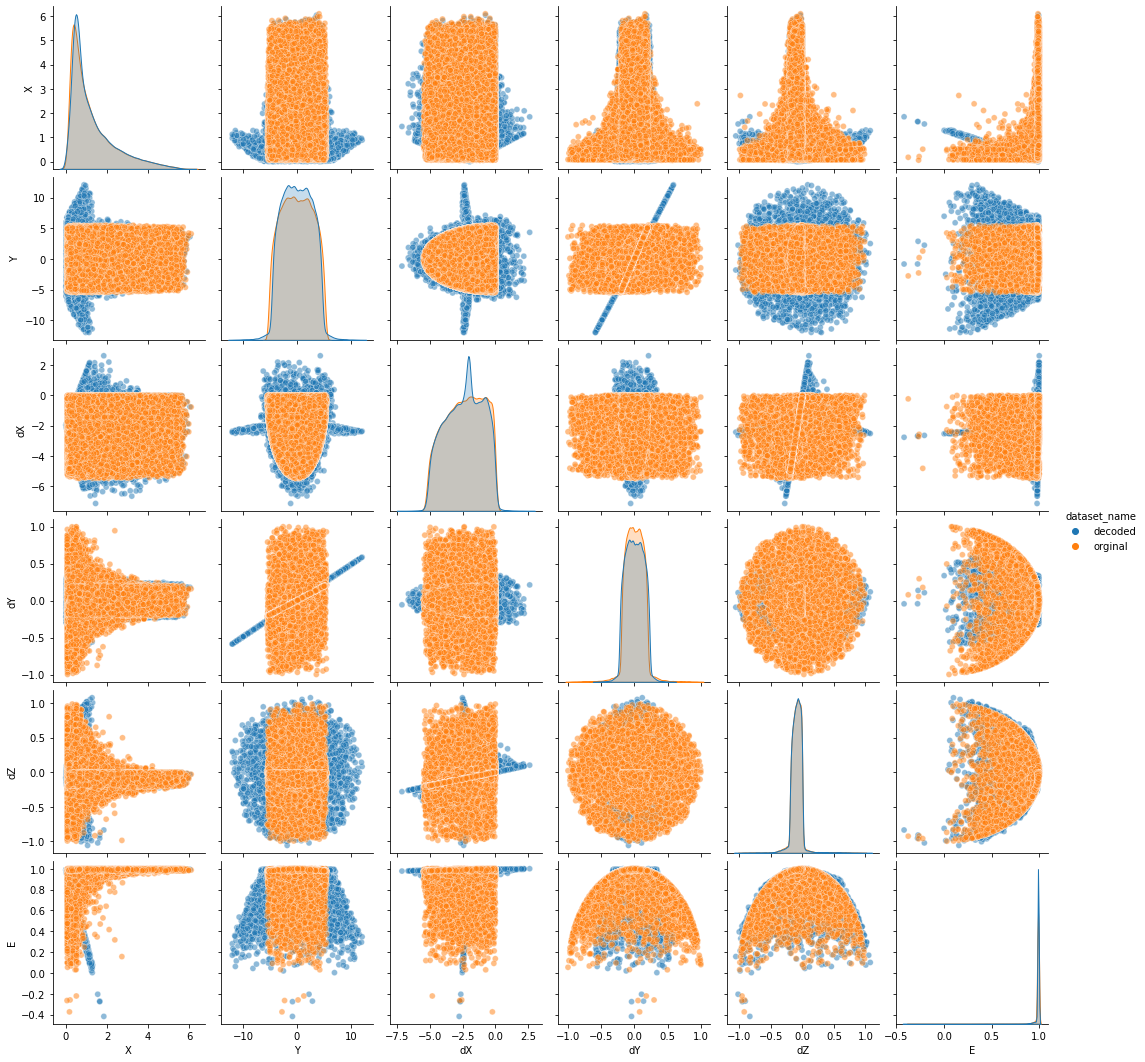

In [23]:
sns.pairplot(sample, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

In [24]:
tmp_2=df_data.iloc[37:38,:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
model.eval()
with torch.no_grad():
    result_encoded_features_2, z_mean_2, z_log_var_2, result_decoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_decoded_features_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [25]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [26]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df

,X,Y,dX,dY,dZ,E
0,2.359750,2.614970,-4.698670,0.100502,-0.180584,0.978411
1,2.334763,2.344309,-4.642483,0.114291,-0.182454,0.983388


In [27]:
encoded_features=[]
model.eval()
for index, feature in enumerate(train_loader):
    with torch.no_grad():
        tmp_encoded_features, z_mean, z_log_var, decoded =model(feature.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

print(encoded_features.shape)

(8000000, 3)


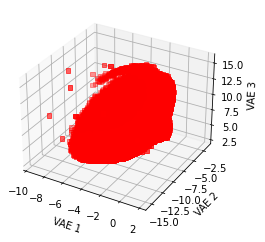

In [28]:
#PRZESTRZEŃ UKRYTA VAE
colors = ['r']
markers = ['s']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for c, m in zip(colors, markers):
    ax.scatter(encoded_features[:,0],encoded_features[:,2],encoded_features[:,1],marker=m,c=c)

ax.set_xlabel('VAE 1')
ax.set_ylabel('VAE 2')
ax.set_zlabel('VAE 3')

plt.show()